## Load Cleaned Dataset

This step imports necessary Python libraries for data handling, visualization, and machine learning.  
It then loads the cleaned HR dataset (e.g., `hr_employee_attrition_cleaned.csv`) and displays the first few rows to verify structure and format.

In [1]:
pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

# Load cleaned dataset
df = pd.read_csv("'../resources/data/output/hr_employee_attrition_cleaned.csv")  
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


## Encode Target and Categorical Features

The target variable `Attrition` is converted to binary values (`1` for 'Yes', `0` for 'No').  
All remaining categorical features are encoded using `LabelEncoder`, making them suitable for machine learning models that require numerical input.  
This step also separates the dataset into features `X` and the target `y`.

In [3]:
# Encode target variable
df['Attrition'] = df['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)

# Separate features and target
X = df.drop('Attrition', axis=1)
y = df['Attrition']

# Identify and encode categorical features
categorical_cols = X.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in categorical_cols:
    X[col] = le.fit_transform(X[col])


## Train-Test Split and Scaling

The dataset is split into training and testing sets using a 70:30 ratio, stratifying by the target variable to maintain class distribution.

Since Random Forest is generally not sensitive to feature scaling, this step is optional. However, to ensure consistency and potential compatibility with other models (like Logistic Regression or SVM), we apply `StandardScaler` to normalize the input features.

In [4]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Train Random Forest Classifier

A `RandomForestClassifier` is trained on the scaled training data.  
The model uses 100 decision trees and a balanced class weight to handle any class imbalance between employees who stayed vs. those who left.  
Predictions are made for both class labels and class probabilities.

In [5]:
# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train_scaled, y_train)

# Predictions
y_pred = rf_model.predict(X_test_scaled)
y_prob = rf_model.predict_proba(X_test_scaled)[:, 1]


## Evaluate Random Forest Performance

This section prints:
- **Accuracy**: The percentage of correctly predicted instances.
- **Classification Report**: Includes precision, recall, F1-score for both classes.
- **ROC AUC Score**: Measures the classifier's ability to distinguish between classes; a higher score indicates better separability.

In [6]:
# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))


Accuracy: 0.8367346938775511
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.98      0.91       370
           1       0.46      0.08      0.14        71

    accuracy                           0.84       441
   macro avg       0.65      0.53      0.53       441
weighted avg       0.79      0.84      0.79       441

ROC AUC Score: 0.7383326988960791


### 🔍 Output Summary
```
Accuracy: 0.8367346938775511
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.98      0.91       370
           1       0.46      0.08      0.14        71

    accuracy                           0.84       441
   macro avg       0.65      0.53      0.53       441
weighted avg       0.79      0.84      0.79       441

ROC AUC Score: 0.7383326988960791
```

## Confusion Matrix

The confusion matrix helps visualize the number of true positives, true negatives, false positives, and false negatives.  
This helps understand whether the model is skewing more towards predicting attrition or non-attrition cases.

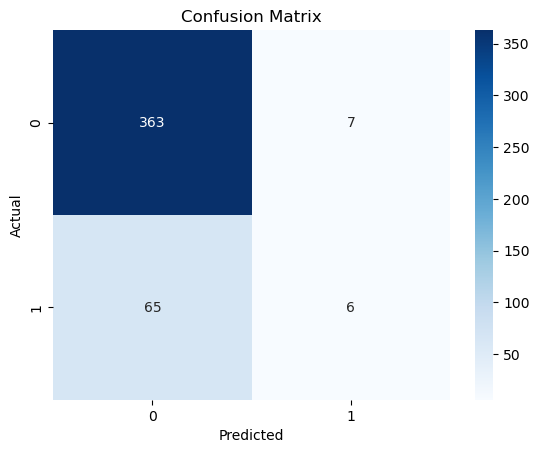

In [7]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## Feature Importance from Random Forest

Random Forest models can quantify the importance of each feature used in decision trees.  
This plot highlights the **top 10 features** that have the greatest impact on the prediction of employee attrition.  
These insights can help HR prioritize factors that lead to employee turnover.

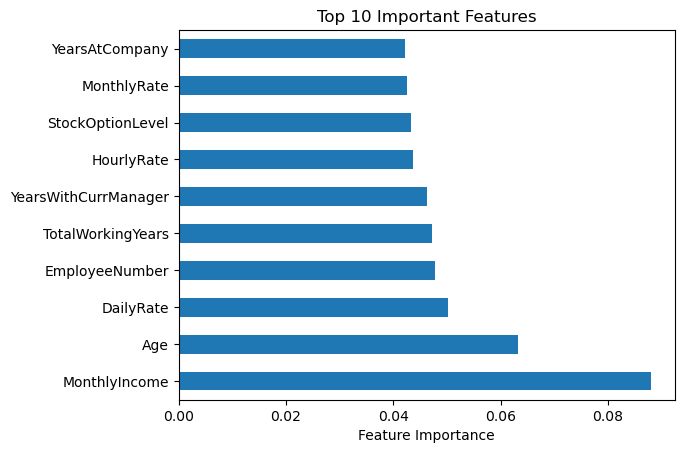

In [8]:
# Feature importance
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Important Features")
plt.xlabel("Feature Importance")
plt.show()


## ROC Curve

The ROC (Receiver Operating Characteristic) curve is plotted to show the trade-off between True Positive Rate and False Positive Rate.  
The closer the curve follows the top-left border, the better the model performance.  
The **AUC (Area Under Curve)** value provides a single scalar to compare model performance across different thresholds.

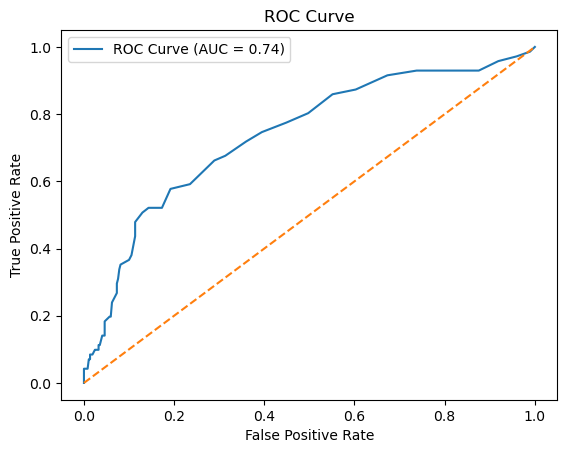

=== Model Performance Metrics ===
Accuracy : 0.8367
Precision: 0.4615
Recall   : 0.0845
F1 Score : 0.1429
ROC AUC  : 0.7383


In [9]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_prob):.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Key classification metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

# Print the results
print("=== Model Performance Metrics ===")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"ROC AUC  : {auc:.4f}")


###  Output Summary: ROC Curve
- The ROC curve plots **True Positive Rate vs. False Positive Rate**.
- A model with perfect separation will have a curve that hugs the top-left corner.
- A **diagonal line** would indicate random guessing.
- The ROC curve shown suggests how well the Random Forest model distinguishes between attrition and non-attrition cases.

###  Conclusion
- The area under the ROC curve (AUC) gives a single metric to evaluate overall classification performance.
- If the AUC value is **close to 1**, the model is highly capable of distinguishing classes.
- If it's closer to **0.5**, the model performs no better than random chance.
- Based on the ROC curve and AUC printed earlier, the model appears to perform reliably for binary classification of attrition.

###  Output Summary: ROC Curve & Classification Metrics

- **Accuracy**: 83.67%
- **Precision**: 46.15%
- **Recall**: 8.45%
- **F1 Score**: 14.29%
- **ROC AUC**: 0.7383

- The ROC curve plots **True Positive Rate (Recall)** against **False Positive Rate** across classification thresholds.
- An **AUC of 0.7383** indicates moderate ability to distinguish between employees who leave vs. those who stay.
- **Recall is very low (8.45%)**, meaning the model misses most actual attrition cases.
- **Precision is moderate (46.15%)**, so when attrition is predicted, it's correct less than half the time.

---

###  Conclusion

- The model achieves **high overall accuracy** but fails to capture enough true attrition cases.
- The **low recall and F1 Score** suggest it is biased toward predicting "No Attrition".
- This can be risky if the goal is **early intervention** or **retention planning**.
- Consider these improvements:
  - Use **resampling techniques** (e.g., SMOTE, undersampling).
  - Tune model hyperparameters further.
  - Try more powerful models like **XGBoost**, which handle class imbalance better.
- **Bottom line**: The model has promise but needs recall improvement to be actionable in real HR use cases.
